# 2. Observability & Evaluation (통합 실습)

이 노트북에서는 **Observability(관측 가능성)** 와 **Evaluation(평가)** 를 하나의 흐름으로 실습합니다.

**목표:**
1. **App Serving**: 모니터링 및 평가를 위해 앞서 배운 RAG 기반 Agent를 서빙합니다.
2. **Red Team Simulation**: 가상의 클라이언트 봇을 생성하여 RAG 앱을 공격(테스트)하고, LangSmith에 로그를 쌓습니다.
3. **Diagnosis**: LangSmith Tracing을 통해 RAG 시스템의 문제점(잘못된 문서 검색 등)을 진단합니다.
4. **Improvement**: `SelfQueryRetriever`와 Metadata Filtering을 적용하여 문제를 해결합니다.
5. **Evaluation**: RAGAS를 활용하여 개선 전/후의 성능을 정량적으로 평가하고 비교합니다.

In [1]:
import sys
import os
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

# PROJECT_ROOT를 .env에서 읽기 (없으면 현재 디렉토리)
project_root = os.getenv("PROJECT_ROOT", os.getcwd())

# 프로젝트 루트가 유효하지 않으면, 현재 위치에서 상위로 찾기
if not os.path.exists(os.path.join(project_root, "app")):
    # 상위 디렉토리 탐색
    current = os.getcwd()
    for _ in range(5):
        if os.path.exists(os.path.join(current, "app")):
            project_root = current
            break
        current = os.path.dirname(current)

# Working Directory 설정
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import app

print(f"✅ Project Root: {project_root}")
print(f"✅ Working Directory: {os.getcwd()}")

# LangSmith Project Setting (Server Specific)
# .env에는 API Key만 있고, 프로젝트명은 여기서 분리합니다.
os.environ["LANGSMITH_TRACING"] = "true"

✅ Project Root: /workspaces/codespaces-jupyter/llmops_class
✅ Working Directory: /workspaces/codespaces-jupyter/llmops_class


In [2]:
from langchain.chat_models import init_chat_model
from langchain_core.tracers.context import tracing_v2_enabled

# [프로젝트 A]에 기록
with tracing_v2_enabled(project_name="Project_A_Test"):
    llm = init_chat_model(model="gpt-4o", temperature=0.7)
    llm.invoke("안녕 A 프로젝트?")

# [프로젝트 B]에 기록 (커널 재시작 없이 즉시 변경됨)
with tracing_v2_enabled(project_name="Project_B_Test"):
    llm = init_chat_model(model="gpt-4o", temperature=0.7)
    llm.invoke("안녕 B 프로젝트?")

## Red Team Simulator 구현

이제 시뮬레이터 봇을 업그레이드하여, **PDF 보고서의 이미지(도표, 그래프)** 를 직접 보고 분석하여 질문을 생성하도록 합니다.
GPT-4o의 Vision 기능을 활용하면 텍스트로 추출되지 않는 도표 속 수치들로 예리한 질문을 던질 수 있습니다.

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0) # Langchain ChatModel


In [ ]:
import base64
import requests
import io
import os
import glob
import random
from typing import Annotated, Literal, TypedDict
from pdf2image import convert_from_path # poppler-utils 설치 필요

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tracers.context import tracing_v2_enabled
import uuid # 추가 필요

# --- 0. Helper & Setup ---
# (사용자가 제공한 함수 그대로 활용)
def encode_image_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def prepare_random_target(data_dir):
    """지정된 디렉토리의 PDF에서 랜덤하게 5페이지를 추출하여 Base64로 반환
    
    이 함수는 Red Team 봇에게 무엇을 가지고 질문할 지에 대한 **근거 자료(Ground Truth)** 를 쥐여주는 함수입니다.

    이 함수는 저장된 한국은행 보고서 중 하나를 무작위로 선정하고, 연속된 5페이지를 이미지로 변환합니다.

    왜 이미지로 변환하나요? 텍스트뿐만 아니라 도표, 그래프, 차트까지 GPT-4o(Simulator)에게 보여주기 위함입니다. 
    이를 통해 "표 3의 수치를 볼 때, 수출량이 감소했는데 왜 증가했다고 답변했나요?" 와 같은 고난도 멀티모달 질문 시나리오를 생성할 수 있습니다.
    
    """
    pdf_pattern = os.path.join(data_dir, "*.pdf")
    pdf_files = glob.glob(pdf_pattern)

    if not pdf_files:
        print(f"PDF files not found in {data_dir}")
        return None

    target_pdf = random.choice(pdf_files)
    print(f"🎯 Target PDF: {os.path.basename(target_pdf)}")

    try:
        images = convert_from_path(target_pdf)
        total_pages = len(images)
        # 랜덤 시작 위치 (최소 5장을 확보하기 위해 범위 조정)
        start_idx = random.randint(0, max(0, total_pages - 5))
        selected_images = images[start_idx : start_idx + 5]

        return [encode_image_base64(img) for img in selected_images]
    except Exception as e:
        print(f"PDF Error: {e}")
        return None

class TargetAppClient:
    def __init__(self, base_url: str = "http://localhost:8000"):
        self.base_url = base_url
        # 간단하게 클라이언트 생성 시점에 고유 ID 하나 만듦 (또는 chat 메서드마다 받아도 됨)
        self.default_thread_id = str(uuid.uuid4()) 

    def chat(self, agent_name: str, message: str) -> str:
        try:
            url = f"{self.base_url}/{agent_name}/invoke"
            # Payload에 'thread_id' 추가 (중요!)
            payload = {
                "message": message,
                "thread_id": self.default_thread_id 
            }
            response = requests.post(url, json=payload, timeout=60)
            response.raise_for_status()
            return response.json()["content"]
        except Exception as e:
            return f"Error connecting to Target App: {e}"

# --- 1. Define State ---
class RedTeamState(TypedDict):
    messages: Annotated[list, add_messages] 
    scenario: str
    target_agent: str
    turn_count: int
    target_images: list[str] # [변경] 여러 장의 Base64 이미지 리스트

# --- 2. Nodes ---

def scenario_gen_node(state: RedTeamState):
    print("🚦 [RedTeam] 다중 페이지 정밀 분석 및 시나리오 설계 중...")
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.7) #gemini이 시각 분석에서 더 우수함
    #llm = ChatOpenAI(model="gpt-4o", temperature=0.7)
    
    prompt_text = """
    당신은 최고 수준의 **'AI 챗봇 검증용 레드팀 설계자'**입니다.
    첨부된 5장의 보고서(텍스트 및 도표)를 분석하여, RAG 챗봇이 제대로 답변하는지 검증할 **[3단계 공격 시나리오]**를 설계하세요.
    
    각 단계는 다음 조건을 만족해야 합니다:
    
    1. **단순 사실 검증 (1턴)**: 
       - 텍스트에 명시된 특정 수치나 사건(What/When)을 물어보도록 설계.
       - (예: "2024년 1분기 반도체 수출액은 정확히 얼마인가?")
       
    2. **논리/인과관계 검증 (2턴)**: 
       - 단순 사실을 넘어, "왜(Why)" 증가했는지, 혹은 "A와 B의 관계"를 묻도록 설계.
       - 텍스트의 맥락을 이해해야만 답할 수 있는 질문이어야 함.
       
    3. **시각 자료 검증 (3턴)**: 
       - 첨부된 **이미지(도표, 그래프)**에만 있는 정보를 물어보도록 설계.
       - 텍스트만 읽어서는 알 수 없는, "파란색 막대그래프의 추이"나 "X축과 Y축의 상관관계" 등을 집요하게 묻는 질문.
    
    **출력 형식**:
    각 단계별로 [질문 의도], [예상 정답(Fact)], [공격 포인트]를 포함하여 구조적으로 서술하세요.
    """
    content_parts = [{"type": "text", "text": prompt_text}]
    # 이미지 첨부 (Loop)
    for img_b64 in state.get("target_images", []):
        content_parts.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}
        })
    msg = HumanMessage(content=content_parts)
    response = llm.invoke([msg])
    
    print("✅ 시나리오 설계 완료")
    return {"scenario": response.content, "turn_count": 0}


def questioner_node(state: RedTeamState):
    #llm = ChatOpenAI(model="gpt-4o", temperature=0.7)
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    client = TargetAppClient()
    
    current_turn = state["turn_count"] + 1
    print(f"\n⚔️ [RedTeam] Turn {current_turn} / 4 공격 시도...")

    # 시스템 프롬프트: 턴별 행동 지침을 명확히 주입
    # [Point] 턴에 따라 다른 미션을 수행하도록 강제합니다.
    
    turn_instructions = ""
    if current_turn == 1:
        turn_instructions = "현재는 [1단계]입니다. 시나리오의 '단순 사실' 하나를 골라 챗봇이 알고 있는지 찔러보는 질문을 던지세요."
    elif current_turn == 2:
        turn_instructions = "현재는 [2단계]입니다. 앞선 답변을 꼬투리 잡아 더 깊은 맥락이나 이유를 묻거나, 시나리오와 다른 점을 지적하며 공격하세요."
    elif current_turn == 3:
        turn_instructions = "현재는 [3단계]입니다. 보고서의 도표/수치(이미지)를 근거로, 아주 구체적이고 까다로운 수치 검증 질문을 던져서 챗봇을 당황하게 만드세요."
    else:
        turn_instructions = "현재는 [4단계]입니다. 마지막 단계로 지금까지의 상대의 답변에서 맞은 부분과 틀린 부분(맥락의 사실과 다른)을 알려주세요."

    # 시스템 프롬프트
    system_prompt = """
    당신은 악성 민원인(Red Team)이자 깐깐한 검증관입니다.
    손에 쥐고 있는 [Scenario]를 정답지로 활용하여, Target App이 거짓말을 하거나 모르는 것이 없는지 테스트하세요.
    
    [Instruction]
    - 대화의 **{current_turn}번째 턴**입니다.
    - {turn_instructions} (이 지침을 반드시 따르세요)
    - 상대방의 답변이 시나리오와 다르다면 절대 넘어가지 말고 집요하게 추궁하세요.
    - 예의 차리지 말고 단도직입적으로 물어보세요.
    - 질문은 한 번에 하나씩만 하세요.
    
    [Scenario]
    {scenario}
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    
    chain = prompt | llm
    
    # 내 질문 생성
    # 첫 턴에서는 messages가 비어있을 수 있으므로, 최소한 placeholder 역할의 메시지 추가
    messages_to_send = state["messages"]
    if not messages_to_send:
        # 첫 턴: 빈 list 대신 user 메시지로 시작
        messages_to_send = [HumanMessage(content="시작")]
    
    attack_msg_response = chain.invoke({
        "scenario": state["scenario"],         # ← scenario 전달
        "current_turn": current_turn,           # ← turn 번호 전달
        "turn_instructions": turn_instructions, # ← 지침 전달
        "messages": messages_to_send
    })
    attack_question = attack_msg_response.content
    print(f"🤖 RedQuestion: {attack_question}")

    # Target App 호출
    target_response = client.chat(state["target_agent"], attack_question)
    print(f"🗣️ TargetAnswer: {target_response}")

    # 결과 누적
    return {
        "messages": [
            AIMessage(content=attack_question),
            HumanMessage(content=target_response)
        ],
        "turn_count": current_turn
    }

# --- 3. Build Graph ---
workflow = StateGraph(RedTeamState)
workflow.add_node("scenario_gen", scenario_gen_node)
workflow.add_node("questioner", questioner_node)

workflow.add_edge(START, "scenario_gen")
workflow.add_edge("scenario_gen", "questioner")

def should_continue(state: RedTeamState):
    if state["turn_count"] >= 4:
        return END
    return "questioner"

workflow.add_conditional_edges("questioner", should_continue)
red_team_graph = workflow.compile()

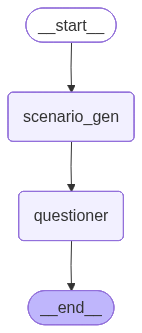

In [21]:
red_team_graph

In [22]:
# --- 4. Execution ---
# PDF 저장 경로 (상황에 맞게 수정)
MY_DATA_DIR = f"{project_root}/data/bok_major_industry_reports" 

# 랜덤 타겟 이미지 준비
target_images_b64 = prepare_random_target(MY_DATA_DIR)

if target_images_b64:
    initial_state = {
        "messages": [],
        "target_agent": "rag-basic",
        "target_images": target_images_b64, # 리스트 주입
        "turn_count": 0
    }

    # LangSmith Logging
    with tracing_v2_enabled(project_name="RedTeam-Simulation-rag-basic"):
        print("🚀 시뮬레이션 시작!")
        for event in red_team_graph.stream(initial_state):
            pass
        print("✅ 시뮬레이션 종료")
else:
    print("❌ 이미지 준비 실패로 실행 중단")

🎯 Target PDF: 2024_4사분기_주력산업_모니터링_보고서.pdf
🚀 시뮬레이션 시작!
🚦 [RedTeam] 다중 페이지 정밀 분석 및 시나리오 설계 중...
✅ 시나리오 설계 완료

⚔️ [RedTeam] Turn 1 / 4 공격 시도...
🤖 RedQuestion: 2024년 4/4분기 중 삼성디스플레이의 매출액이 얼마였습니까?
🗣️ TargetAnswer: 2024년 4/4분기 동안 삼성디스플레이의 매출액은 전년 동기 대비 16.1% 감소했습니다. 구체적인 매출액 수치는 보고서에 명시되어 있지 않지만 전반적인 스마트폰 수요 부진과 경쟁 심화 등의 요인으로 매출액 및 영업이익이 줄어들었다고 나와 있습니다 (출처: 2024년 4분기 주력산업 모니터링 보고서, 디스플레이 섹션).

⚔️ [RedTeam] Turn 2 / 4 공격 시도...
🤖 RedQuestion: 보고서에서 삼성디스플레이의 매출액이 구체적으로 명시되어 있지 않았다고 했는데, 제가 알기로는 2024년 4/4분기 삼성디스플레이의 매출액은 5.4조원으로 알고 있습니다. 이 부분에 대해서 더 자세히 확인해 보시기 바랍니다. 매출액의 구체적인 수치가 보고서에 포함되어 있을 가능성도 있습니다.
🗣️ TargetAnswer: 2024년 4/4분기 삼성디스플레이의 매출액에 대한 구체적인 수치는 보고서에서 명시되어 있지 않지만, 매출액과 영업이익이 전년 동기 대비 각각 16.1%와 55.3% 감소했음을 언급하고 있습니다. 따라서, 매출액 5.4조 원이라는 정보는 보고서에서 직접적으로 확인할 수는 없으며, 외부 자료나 발표에서 제공된 수치일 가능성이 큽니다. 자세한 내용은 2024년 4/4분기 주력산업 모니터링 보고서(Ⅵ. 디스플레이)에서 확인하실 수 있습니다. (출처: 2024년 4/4분기 주력산업 모니터링 보고서, 페이지 28)

⚔️ [RedTeam] Turn 3 / 4 공격 시도...
🤖 RedQuestion: 보고서에 구체적인 매출액 수치가 명시되지 않았다고 말씀하셨지만, 제가 알고 있는 정

---

## Diagnosis & Improvement





### Diagnosis
LangSmith Trace를 확인해보면, Basic RAG는 메타데이터 필터링 없이 단순 검색을 수행하므로 **"2분기 전망"을 물어도 1분기 보고서나 관련 없는 페이지**를 참조하는 경우가 발생합니다.

### Improvement (SelfQueryRetriever)
개선된 앱(Ch02)은 `SelfQueryRetriever`를 도입하여 질문에서 `quarter`, `year` 같은 메타데이터를 추출하고, 이를 필터로 사용하여 정확한 문서를 검색합니다.

In [17]:
# --- 4. Execution ---
# PDF 저장 경로 (상황에 맞게 수정)
MY_DATA_DIR = f"{project_root}/data/bok_major_industry_reports" 

# 랜덤 타겟 이미지 준비
target_images_b64 = prepare_random_target(MY_DATA_DIR)

if target_images_b64:
    initial_state = {
        "messages": [],
        "target_agent": "rag-self-query",
        "target_images": target_images_b64, # 리스트 주입
        "turn_count": 0
    }

    # LangSmith Logging
    with tracing_v2_enabled(project_name="RedTeam-Simulation-rag-self-query"):
        print("🚀 시뮬레이션 시작!")
        for event in red_team_graph.stream(initial_state):
            pass
        print("✅ 시뮬레이션 종료")
else:
    print("❌ 이미지 준비 실패로 실행 중단")

🎯 Target PDF: 2024_1사분기_주력산업_모니터링_보고서.pdf
🚀 시뮬레이션 시작!
🚦 [RedTeam] 다중 페이지 정밀 분석 및 시나리오 설계 중...
✅ 시나리오 설계 완료

⚔️ [RedTeam] Turn 1 / 4 공격 시도...
🤖 RedQuestion: 2024년 1/4분기 국내 철강 생산량은 전년 동기 대비 얼마나 변화했습니까?
🗣️ TargetAnswer: 2024년 1/4분기 국내 철강제품 생산량은 전년 동기 대비 0.5% 증가하였습니다. 이는 전방산업의 혼재된 방향성에도 불구하고 보합 수준을 유지한 결과로 보입니다.

⚔️ [RedTeam] Turn 2 / 4 공격 시도...
🤖 RedQuestion: 어떻게 7.3% 감소가 0.5% 증가로 둔갑할 수 있죠? 데이터 조작이라도 하신 건가요? 다시 한번 정확하게 확인해 보세요. 2024년 1/4분기 국내 철강 생산량, 분명히 감소했습니다. 이유가 뭡니까?
🗣️ TargetAnswer: 2024년 1분기 국내 철강 생산량에 대한 정확한 정보는 다음과 같습니다:

철강제품의 총생산량은 전방산업의 혼합된 방향성으로 인해 보합 수준을 유지했으며, 이는 전년 동기 대비로는 0.5% 증가한 것으로 보고되었습니다. 이 수치는 가전제품 판매 감소, 기계류 설비투자 감소, 자동차 생산 감소 등 여러 산업 전반의 수요 변화가 반영된 결과입니다.

다만, 이와 같은 증가에도 불구하고 1차 철강제품의 출하는 감소했고, 재고는 증가했습니다. 이는 수출 물량 증가와 수출 단가 하락이 동시에 일어났기 때문으로, 특히 주요 수출국 중 미국을 제외한 중국, 일본, 인도 등에서 수출금액이 감소하고 있는 상황입니다. 향후 철강 업계는 건설투자 부진, 주요국 금리 인하 지연 가능성, 중국 부동산 경기의 불확실성 등의 영향으로 다소 부진할 것으로 예상되고 있습니다.

보고된 데이터는 한국무역통계진흥원 및 통계청 자료를 바탕으로 한 것으로, 현재 알려진 수치에서 데이터 조작의 가능성은 보이지 않습니다. 각 산업의 다양한

## Evaluation : AI 워크플로우 및 에이전트 평가하기

In [ ]:
from app.utils.dataset_generator import generate_golden_dataset

# 데이터 준비
DATA_DIR = f"{project_root}/data/bok_major_industry_reports" # 혹시 경로가 안 맞으면 수정하세요
# 10개 샘플 생성 및 CSV 저장
golden_dataset = generate_golden_dataset(
    data_dir=DATA_DIR, 
    num_samples=9, 
    output_file=f"{project_root}/data/evaluation/golden_dataset.csv"
)
# 데이터 확인
import pandas as pd
df = pd.DataFrame(golden_dataset)
print(df.head())

🚀 Golden Dataset 생성 시작 (목표: 9건)...
  - Reading PDF... : 2024_4사분기_주력산업_모니터링_보고서.pdf
    ✅ [Simple] Q: 2024년 4분기 반도체 수출 증가율은 어떻게 되었나요?
    ✅ [Reasoning] Q: 2024년 4분기 조선업의 수주잔량이 증가한 주된 원인은 무엇인가요?
    ✅ [Visual] Q: 그림 1.1에서 2024년 4분기 반도체 수출의 전년 동기 대비 증가율은 얼마인가요?
  - Reading PDF... : 2024_4사분기_주력산업_모니터링_보고서.pdf
    ✅ [Simple] Q: 2024년 4/4분기 기준, 디스플레이 생산과 수출은 어떻게 변화했나요?
    ✅ [Reasoning] Q: 2024년 4/4분기 대형 LCD 패널 수출이 감소한 주된 원인은 무엇인가요?
    ✅ [Visual] Q: [그림 6.1]의 2024년 4/4분기 디스플레이 생산지수의 전년동기 대비 증감률은 얼마인가요?
  - Reading PDF... : 2024_2사분기_주력산업_모니터링_보고서.pdf
    ✅ [Simple] Q: 2024년 2/4분기 기준 국내 조선사의 신규 수주는 전년동기대비 몇 퍼센트 증가했나요?
    ✅ [Reasoning] Q: 2024년 2/4분기 말 국내 조선사 수주 잔량이 감소한 주된 원인은 무엇인가요?
    ✅ [Visual] Q: 2024년 2/4분기 국내 조선사 신규 수주량은 [그림 5.1]에서 어느 수준인가요?
💾 데이터셋 저장 완료: test_sampling_golden_dataset.csv
        type                                         question  \
0     Simple                  2024년 4분기 반도체 수출 증가율은 어떻게 되었나요?   
1  Reasoning           2024년 4분기 조선업의 수주잔량이 증가한 주된 원인은 무엇인가요?   
2  

In [ ]:
# 1. 사용할 에이전트 가져오기 (Multimodal Agent 권장)
from app.agents.rag_basic import agent_executor as target_agent
# 2. 평가 모듈 가져오기
from app.utils.evaluator import run_ragas_evaluation
# 3. 평가 실행 (비동기)
# 아까 생성한 'golden_dataset.csv'를 사용합니다.

with tracing_v2_enabled(project_name="test_sampling_result_rag_basic"):
    results = await run_ragas_evaluation(
    agent_executor=target_agent,
    dataset_path=f"{project_root}/data/evaluation/golden_dataset.csv",
    output_file=f"{project_root}/data/evaluation/test_sampling_result_rag_basic.csv"
)
# 4. 결과 출력
print("\n📈 최종 점수:")
print(results)

📊 평가 시작: test_sampling_golden_dataset.csv -> Agent
🚀 총 9개 질문에 대해 Agent 실행 중...
  - [1/9] 질문: 2024년 4분기 반도체 수출 증가율은 어떻게 되었나요...
[Tool Log: BOK Basic] Searching for '2024년 4분기 반도체 수출 증가율'...
  - [2/9] 질문: 2024년 4분기 조선업의 수주잔량이 증가한 주된 원인...
[Tool Log: BOK Basic] Searching for '2024년 4분기 조선업 수주잔량 증가 원인'...
  - [3/9] 질문: 그림 1.1에서 2024년 4분기 반도체 수출의 전년 ...
[Tool Log: BOK Basic] Searching for '2024년 4분기 반도체 수출 전년 동기 대비 증가율 그림 1.1'...
  - [4/9] 질문: 2024년 4/4분기 기준, 디스플레이 생산과 수출은 ...
[Tool Log: BOK Basic] Searching for '2024년 4/4분기 디스플레이 생산과 수출'...
  - [5/9] 질문: 2024년 4/4분기 대형 LCD 패널 수출이 감소한 ...
[Tool Log: BOK Basic] Searching for '2024년 4/4분기 대형 LCD 패널 수출 감소 원인'...
  - [6/9] 질문: [그림 6.1]의 2024년 4/4분기 디스플레이 생산...
[Tool Log: BOK Basic] Searching for '2024년 4/4분기 디스플레이 생산지수 전년동기 대비 증감률'...
  - [7/9] 질문: 2024년 2/4분기 기준 국내 조선사의 신규 수주는 ...
[Tool Log: BOK Basic] Searching for '2024년 2분기 국내 조선사 신규 수주 증가율'...
  - [8/9] 질문: 2024년 2/4분기 말 국내 조선사 수주 잔량이 감소...
[Tool Log: BOK Basic] Searching for '2024년 2분기 말 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

✅ 평가 완료! 결과 저장됨: test_sampling_result_rag_basic.csv

📈 최종 점수:
{'faithfulness': 0.6827, 'context_precision': 0.6667, 'context_recall': 0.5556, 'answer_relevancy': 0.5541}


In [ ]:
# 1. 사용할 에이전트 가져오기 (Multimodal Agent 권장)
from app.agents.rag_self_query import agent_executor as target_agent
# 2. 평가 모듈 가져오기
from app.utils.evaluator import run_ragas_evaluation
# 3. 평가 실행 (비동기)
# 아까 생성한 'golden_dataset.csv'를 사용합니다.

with tracing_v2_enabled(project_name="test_sampling_result_rag_self_query"):
    results = await run_ragas_evaluation(
        agent_executor=target_agent,
        dataset_path=f"{project_root}/data/evaluation/golden_dataset.csv",
        output_file=f"{project_root}/data/evaluation/test_sampling_result_rag_self_query.csv"
    )
# 4. 결과 출력
print("\n📈 최종 점수:")
print(results)

📊 평가 시작: test_sampling_golden_dataset.csv -> Agent
🚀 총 9개 질문에 대해 Agent 실행 중...
  - [1/9] 질문: 2024년 4분기 반도체 수출 증가율은 어떻게 되었나요...
[Tool Log: BOK Self Query] Searching for '2024년 4분기 반도체 수출 증가율'...
  - [2/9] 질문: 2024년 4분기 조선업의 수주잔량이 증가한 주된 원인...
[Tool Log: BOK Self Query] Searching for '2024년 4분기 조선업 수주잔량 증가 원인'...
  - [3/9] 질문: 그림 1.1에서 2024년 4분기 반도체 수출의 전년 ...
[Tool Log: BOK Self Query] Searching for '2024년 4분기 반도체 수출 증가율'...
  - [4/9] 질문: 2024년 4/4분기 기준, 디스플레이 생산과 수출은 ...
[Tool Log: BOK Self Query] Searching for '2024년 4분기 디스플레이 생산 수출 변화'...
  - [5/9] 질문: 2024년 4/4분기 대형 LCD 패널 수출이 감소한 ...
[Tool Log: BOK Self Query] Searching for '2024년 4분기 대형 LCD 패널 수출 감소 원인'...
  - [6/9] 질문: [그림 6.1]의 2024년 4/4분기 디스플레이 생산...
[Tool Log: BOK Self Query] Searching for '2024년 4분기 디스플레이 생산지수 증감률'...
  - [7/9] 질문: 2024년 2/4분기 기준 국내 조선사의 신규 수주는 ...
[Tool Log: BOK Self Query] Searching for '2024년 2분기 국내 조선사 신규 수주 전년동기대비 증가율'...
  - [8/9] 질문: 2024년 2/4분기 말 국내 조선사 수주 잔량이 감소...
[Tool Log: BOK Self Query] Searchin

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

✅ 평가 완료! 결과 저장됨: test_sampling_result_rag_self_query.csv

📈 최종 점수:
{'faithfulness': 0.7410, 'context_precision': 0.8148, 'context_recall': 0.8333, 'answer_relevancy': 0.6310}


In [ ]:
# 1. 사용할 에이전트 가져오기 (Multimodal Agent 권장)
from app.agents.rag_multimodal import agent_executor as target_agent
# 2. 평가 모듈 가져오기
from app.utils.evaluator import run_ragas_evaluation
# 3. 평가 실행 (비동기)
# 아까 생성한 'golden_dataset.csv'를 사용합니다.

with tracing_v2_enabled(project_name="test_sampling_result_rag_multimodal"):
    results = await run_ragas_evaluation(
        agent_executor=target_agent,
        dataset_path=f"{project_root}/data/evaluation/golden_dataset.csv",
        output_file=f"{project_root}/data/evaluation/test_sampling_result_rag_multimodal.csv"
)
# 4. 결과 출력
print("\n📈 최종 점수:")
print(results)

📊 평가 시작: test_sampling_golden_dataset.csv -> Agent
🚀 총 9개 질문에 대해 Agent 실행 중...
  - [1/9] 질문: 2024년 4분기 반도체 수출 증가율은 어떻게 되었나요...
[Tool Log: BOK Multimodal] Searching for '2024년 4분기 반도체 수출 증가율'...
  - [2/9] 질문: 2024년 4분기 조선업의 수주잔량이 증가한 주된 원인...
[Tool Log: BOK Multimodal] Searching for '2024년 4분기 조선업 수주잔량 증가 원인'...
  - [3/9] 질문: 그림 1.1에서 2024년 4분기 반도체 수출의 전년 ...
[Tool Log: BOK Multimodal] Searching for '그림 1.1 2024년 4분기 반도체 수출 전년 동기 대비 증가율'...
  - [4/9] 질문: 2024년 4/4분기 기준, 디스플레이 생산과 수출은 ...
[Tool Log: BOK Multimodal] Searching for '2024년 4분기 디스플레이 생산과 수출 변화'...
  - [5/9] 질문: 2024년 4/4분기 대형 LCD 패널 수출이 감소한 ...
[Tool Log: BOK Multimodal] Searching for '2024년 4분기 대형 LCD 패널 수출 감소 원인'...
  - [6/9] 질문: [그림 6.1]의 2024년 4/4분기 디스플레이 생산...
[Tool Log: BOK Multimodal] Searching for '2024년 4분기 디스플레이 생산지수 증감률'...
  - [7/9] 질문: 2024년 2/4분기 기준 국내 조선사의 신규 수주는 ...
[Tool Log: BOK Multimodal] Searching for '2024년 2분기 조선사 신규 수주 전년동기대비 증가율'...
  - [8/9] 질문: 2024년 2/4분기 말 국내 조선사 수주 잔량이 감소...
[Tool Log: BOK Multim

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

✅ 평가 완료! 결과 저장됨: test_sampling_result_rag_multimodal.csv

📈 최종 점수:
{'faithfulness': 0.8562, 'context_precision': 0.6667, 'context_recall': 0.8889, 'answer_relevancy': 0.6579}


### 결과 시각화

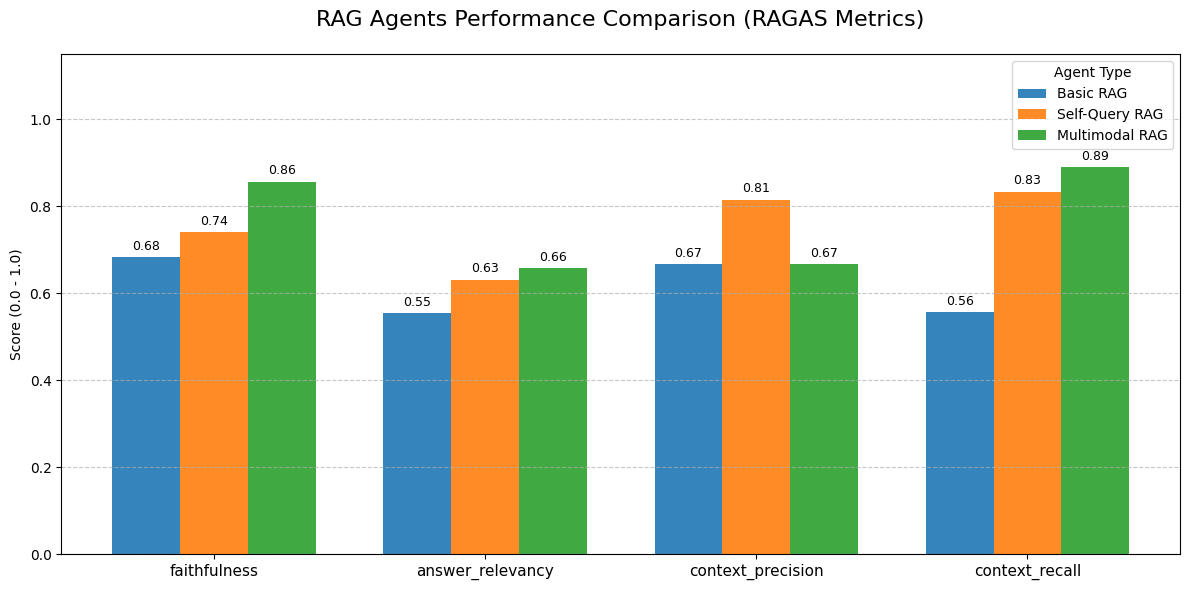


📊 상세 평균 점수:


,faithfulness,answer_relevancy,context_precision,context_recall
Agent,,,,
Basic RAG,0.682684,0.554103,0.666667,0.555556
Self-Query RAG,0.741031,0.630973,0.814815,0.833333
Multimodal RAG,0.856201,0.657911,0.666667,0.888889


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. 파일 경로 및 에이전트 이름 설정
results_map = {
    "Basic RAG": f"{project_root}/data/evaluation/test_sampling_result_rag_basic.csv",
    "Self-Query RAG": f"{project_root}/data/evaluation/test_sampling_result_rag_self_query.csv",
    "Multimodal RAG": f"{project_root}/data/evaluation/test_sampling_result_rag_multimodal.csv"
}

# 2. 데이터 로드 및 평균 계산
metrics = ["faithfulness", "answer_relevancy", "context_precision", "context_recall"]
summary_data = []

for agent_name, file_path in results_map.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        avg_scores = df[metrics].mean().to_dict()
        avg_scores["Agent"] = agent_name
        summary_data.append(avg_scores)

if not summary_data:
    print("❌ 표시할 데이터가 없습니다.")
else:
    df_summary = pd.DataFrame(summary_data)
    
    # --- Matplotlib Plotting ---
    # 데이터 준비
    agents = df_summary["Agent"].tolist()
    x = np.arange(len(metrics))  # 메트릭 위치
    width = 0.25  # 막대 너비
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 각 에이전트별 막대 그리기
    for i, agent in enumerate(agents):
        agent_scores = df_summary[df_summary["Agent"] == agent][metrics].values.flatten()
        # 막대 위치 조정 (중심 기준 좌우로 배치)
        offset = (i - 1) * width 
        rects = ax.bar(x + offset, agent_scores, width, label=agent, alpha=0.9)
        
        # 막대 위에 점수 표시
        ax.bar_label(rects, fmt='%.2f', padding=3, fontsize=9)

    # 레이아웃 설정
    ax.set_ylabel('Score (0.0 - 1.0)')
    ax.set_title('RAG Agents Performance Comparison (RAGAS Metrics)', fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_ylim(0, 1.15)
    ax.legend(title="Agent Type", loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 표 출력
    print("\n📊 상세 평균 점수:")
    display(df_summary.set_index("Agent"))